In [ ]:
from nuscenes.nuscenes import NuScenes
directory = r"/home/kfir/workspace/nuScenes/v1.0-trainval"
nusc = NuScenes(version="v1.0-trainval", dataroot=directory, verbose=False)

In [ ]:
%load_ext autoreload
%autoreload 2
from simulation import NuscenesSimulation

class DummyModel():
    def __init__(self):
        self.mm = True
        
scene = 690
dummy_model = DummyModel()
video_list={'video' : False, 'video_debug': False, 'video_pf': False, 'video_pf_xy': False, 'dynamic_tracker': False}
sim = NuscenesSimulation(nusc=nusc, model=dummy_model, scene_id=scene, Nmax=1200, video_list=video_list, save_processed=True)

#data = NuscenesProcessedDatabase(scene_id=scene)

In [ ]:
from nuscenes.utils.geometry_utils import transform_matrix
from pyquaternion import Quaternion
from nuscenes.utils.geometry_utils import view_points

def projectRadarOnCamera(nusc, pc, im, cs_record, min_dist: float = 1.0):

    pc.translate(-np.array(cs_record['translation']))
    pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix.T)

    # Fifth step: actually take a "picture" of the point cloud.
    # Grab the depths (camera frame z axis points away from the camera).
    depths = pc.points[2, :]

    # Retrieve the color from the depth.
    coloring = depths

    # Take the actual picture (matrix multiplication with camera-matrix + renormalization).
    points = view_points(pc.points[:3, :], np.array(cs_record['camera_intrinsic']), normalize=True)

    # Remove points that are either outside or behind the camera. Leave a margin of 1 pixel for aesthetic reasons.
    # Also make sure points are at least 1m in front of the camera to avoid seeing the lidar points on the camera
    # casing for non-keyframes which are slightly out of sync.
    mask = np.ones(depths.shape[0], dtype=bool)
    mask = np.logical_and(mask, depths > min_dist)
    mask = np.logical_and(mask, points[0, :] > 1)
    mask = np.logical_and(mask, points[0, :] < im.shape[0] - 1)
    mask = np.logical_and(mask, points[1, :] > 1)
    mask = np.logical_and(mask, points[1, :] < im.shape[1] - 1)
    points = points[:, mask]
    coloring = coloring[mask]

    return points, coloring, im

nusc_map = sim.dataset.nusc_map
video_with_priors = True

t = 500
img = sim.dataset.getSyncedImage(t)
zw, covw, prior, dw, video_data, nusc_map = sim.dataset.getData(t, GT=True)
pc = sim.dataset.getEGORadarData(t, video_data["pos"], video_data["rot_gt"])

points, coloring, im = projectRadarOnCamera(nusc, pc, img, sim.dataset.cs_record_camera)
#video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, translation, debug_info = data.load(t)
fig, ax = plt.subplots(1, 1, figsize=(18, 32))
ax.imshow(im)
print(points.shape)
ax.scatter(points[0, :], points[1, :], c=coloring, s=30)
ax.axis('off')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Text(1.3, 4.88, '$(x_k^*, y_k^*)$')

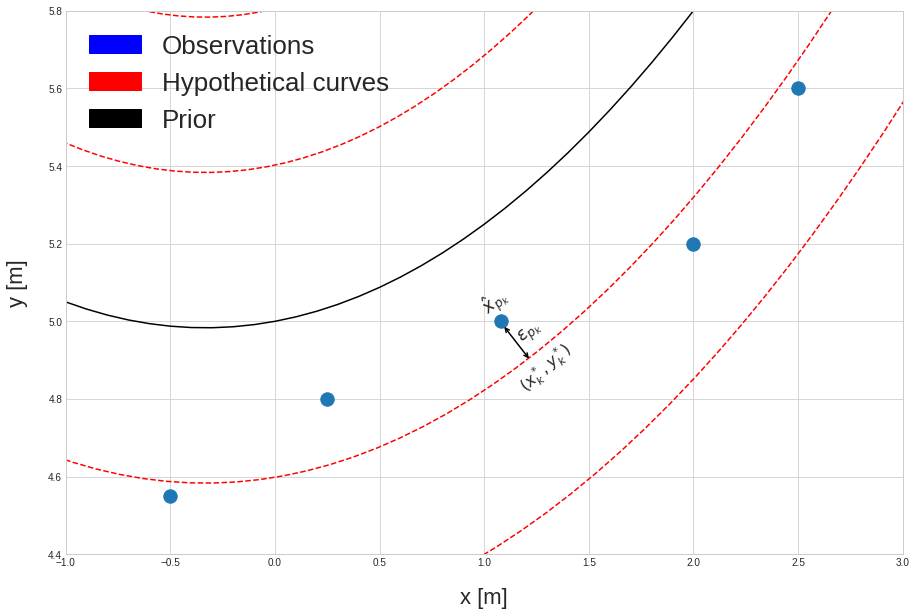

In [33]:
%load_ext autoreload
%autoreload 2
from plotting import *
from database import SimulatedProcessedDatabase
from video import SimulationVideo
from tqdm import tqdm
import matplotlib.patches as mpatches

def createHypothesis(a0,a1,a2,x0,y0,t0,x,y):
    a0_tag = a0+y0-a1*x0+a2*x0**2
    a1_tag = a1-2*a2*x0
    denom = np.sqrt(1+(2*a2*x+a1_tag)**2)
    x_tag = x + t0 * (2*a2*x+a1_tag)/denom
    y_tag = a0_tag+a1_tag*x+a2*x**2-t0/denom

    return x_tag, y_tag


fig, ax = plt.subplots(1,1,figsize=(15,10))
#ax.axis('equal')

a0, a1, a2 = 5, 0.1, 0.15
x = np.arange(-10,10,0.1)
y = a0 + a1 * x + a2 * x**2
x0 = 0
y0 = 0
ax.plot(x,y, color='black')
T0 = [-0.8, -0.4, 0.4, 0.8]
for t0 in T0:
    xtag, ytag = createHypothesis(a0,a1,a2,x0,y0,t0,x,y)
    ax.plot(xtag,ytag,'--', color='red')
    
ax.set_xlim([-1,3])
ax.set_ylim([4.4,5.8])

ax.scatter(1.08, 5, s=180)
#ax.text(1.1, 5.06, '$\hat{x}_{p_k}$',
        #fontsize = 25, rotation=0)
#ax.annotate("", xy=(1.2, 4.9), xytext=(1.08, 5),
            #arrowprops=dict(arrowstyle="<->"), fontsize=20)
#ax.text(1.14, 4.96, '$\epsilon_{p_k}$',
        #fontsize = 18, rotation=30)

#ax.scatter(1.2, 4.9, s=180, color='green')

#ax.text(1.04, 4.74, '$(x{*}_k^{(m)}, y{*}_k^{(m)})$',
        #fontsize = 20, rotation=40)

#ax.text(1.5, 5.6, '$P^{(m)}$',
        #fontsize = 25, rotation=20)

#ax.text(1.8, 5.4, '$P^{(m)}_{cand}$',
        #fontsize = 25, rotation=20)

#ax.text(2.1, 5.1, '$P^{(m+1)}$',
        #fontsize = 25, rotation=20)

plt.xlabel('x [m]', fontsize=22, labelpad=20.0)
plt.ylabel('y [m]', fontsize=22, labelpad=20.0)
#ax.set_title(label=r"Detection of object of the form $x = f(y)$", y=1.03, fontsize=36)

ax.scatter(4.8, 0.75, s=180,color="tab:blue")


ax.scatter(2, 5.2, s=180,color="tab:blue")


ax.scatter(2.5, 5.6, s=180,color="tab:blue")


ax.scatter(-0.5, 4.55, s=180,color="tab:blue")

ax.scatter(0.25, 4.8, s=180,color="tab:blue")

observations_patch = mpatches.Patch(color='blue', label='Observations')
curves_patch = mpatches.Patch(color='red', label='Hypothetical curves')
prior_patch = mpatches.Patch(color='black', label='Prior')
ax.legend(handles=[observations_patch, curves_patch, prior_patch], prop={'size': 26})

x_start, y_start = 1.09, 4.99
x_end, y_end = 1.22, 4.9
arrow_props = dict(arrowstyle='<->', color='black', lw=1.5)
ax.annotate("", xy=(x_end, y_end), xytext=(x_start, y_start), arrowprops=arrow_props)
ax.text(1.22, 4.97, r'$\epsilon_{p_k}$', ha='center', va='center', fontsize=18, rotation=42)
ax.text(1.05, 5.05, r'$\hat{x}_{p_k}$', ha='center', va='center', fontsize=18, rotation=42)
ax.text(1.3, 4.88, r'$(x_k^*, y_k^*)$', ha='center', va='center', fontsize=16, rotation=42)